EDA -> Feature Engineering -> Modelling -> Model Validation

# EDA

In [286]:
import pandas as pd

In [287]:
# test_features = pd.read_csv('test_set_features.csv')
raw_train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')

In [288]:
drop_columns = [
    'health_insurance'
    , 'employment_occupation'
    , 'employment_industry'
]

cleaned_train_features = raw_train_features.drop(columns=drop_columns)

In [289]:
survey_data = cleaned_train_features.merge(right=train_labels, how='inner', on='respondent_id')

# Feature Engineering

In [290]:
from sklearn.model_selection import train_test_split

X = survey_data.drop(columns=['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])
y = survey_data['seasonal_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [291]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np


imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False)


# ---- X_train ----
# X_train SimpleImputer
X_train_imp = pd.DataFrame(imp.fit_transform(X_train),
                           index=X_train.index,
                           columns=X.columns)

# X_train OneHotEncoder
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_imp),
                           index=X_train_imp.index,
                           columns=np.hstack(ohe.categories_))
X_train_ohe.columns = ohe.get_feature_names(X_train_imp.columns) # Set column names of the X_train ohe dataframe



# ---- X_test ----
# X_test SimpleImputer
X_test_imp = pd.DataFrame(imp.transform(X_test),
                          index=X_test.index,
                          columns=X_test.columns)

# X_test OneHotEncoder
X_test_ohe = pd.DataFrame(ohe.transform(X_test_imp),
                          index=X_test_imp.index,
                          columns=np.hstack(ohe.categories_))
X_test_ohe.columns = ohe.get_feature_names(X_test_imp.columns) # Set column names of the X_test ohe dataframe



# Baseline Modelling: Logistic Regression

In [292]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=1)
model_log = logreg.fit(X_train_ohe, y_train)
model_log

LogisticRegression(random_state=1)

# Baseline Model Validation: Residuals and Confusion Matrix

In [293]:
y_hat_train = logreg.predict(X_train_ohe)

train_residuals = np.abs(y_train - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (Counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (Proportion)").value_counts(normalize=True))

0    15592
1     4438
Name: Residuals (Counts), dtype: int64

0    0.778432
1    0.221568
Name: Residuals (Proportion), dtype: float64


In [294]:
y_hat_test = logreg.predict(X_test_ohe)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (Counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (Proportion)").value_counts(normalize=True))

0    5285
1    1392
Name: Residuals (Counts), dtype: int64

0    0.791523
1    0.208477
Name: Residuals (Proportion), dtype: float64


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      3639
           1       0.78      0.75      0.77      3038

    accuracy                           0.79      6677
   macro avg       0.79      0.79      0.79      6677
weighted avg       0.79      0.79      0.79      6677



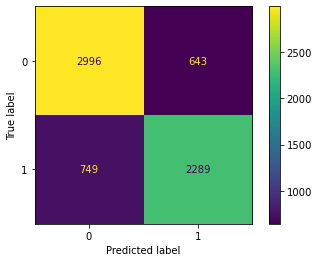

In [295]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_hat_test)
cm

plot_confusion_matrix(logreg, X_test_ohe, y_test)
print(classification_report(y_test, y_hat_test))

# Baseline Model Validation: Cross-Validation

In [301]:
from sklearn.model_selection import cross_val_score

X_imp = pd.DataFrame(imp.fit_transform(X),
                     index=X.index,
                     columns=X.columns)
X_imp_ohe = pd.DataFrame(ohe.fit_transform(X_imp),
                         index=X.index,
                         columns=np.hstack(ohe.categories_))
X_imp_ohe.columns = ohe.get_feature_names(X_imp.columns) # Set column names of the X_train ohe dataframe

cross_val_score(logreg, X_imp_ohe, y, cv=5)

array([0.77442905, 0.78098091, 0.77644636, 0.78412282, 0.77625913])

# Baseline Model Validation: ROC and AUC curve

AUC: 0.8613590318184556
AUC: 0.8613590318184556


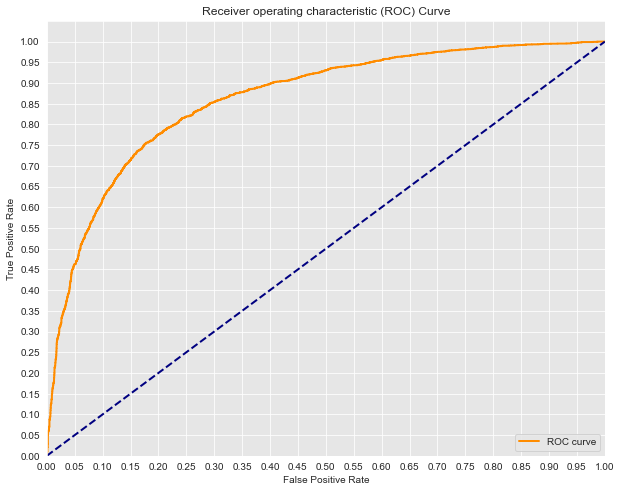

In [305]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_score = logreg.fit(X_train_ohe, y_train).decision_function(X_test_ohe)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC: {}'.format(auc(fpr, tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()